In [88]:
!pip install category_encoders

In [89]:
# =================================
# LIBRARIES
# =================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [90]:
# =================================
# LOAD & PREVIEW DATA
# =================================

# Create a directory for the data
!mkdir -p data

# Download the dataset from data.transportation.gov
!wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset
data_path = "data/raw_data.csv"
df_full = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df_full.head()

#print(df.columns)


--2025-03-21 23:04:10--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.transportation.gov (data.transportation.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [         <=>        ]  91.30M  5.54MB/s    in 16s     

2025-03-21 23:04:27 (5.65 MB/s) - ‘data/raw_data.csv’ saved [95738829]



,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,TOS,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Injuries,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Trespasser Inuries (Subtotal),Trespasser Serious Injuries (Subtotal),Total Serious Injuries,Person List
0,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,Bus was parked in <REDACTED> <REDACTED> and an...,...,0,0,0,0,0,0,0,0,0,NaN
1,40035,Central Florida Regional Transportation Authority,65863,Bus,Demand Response,DR,DO,False,2024,Another vehicle made other front contact with ...,...,1,0,0,0,0,0,0,0,0,I Operator Inside Adult (19 to 60) F ; I ...
2,50027,Metro Transit,57628,Rail,Light Rail,LR,DO,True,2024,Officers responded to a shooting . Suspect was...,...,0,0,0,0,0,0,0,0,0,F Passenger Adult (19 to 60) M
3,90026,San Diego Metropolitan Transit System,78661,Rail,Light Rail,LR,DO,True,2024,San Diego Police took a female into custody af...,...,0,0,0,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M Y
4,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,operator was driving down <REDACTED> <REDACTED...,...,1,0,0,0,0,0,0,0,0,I Occ Other Veh Adult (19 to 60) M


In [91]:

# =================================
# CLEANING & FEATURE ENGINEERING
# =================================
#df['Year'] = df['Event Date'].dt.year
#df['Month'] = df['Event Date'].dt.month
#df['Weekday'] = df['Event Date'].dt.weekday

# Selected Columns
# Define the list of columns to keep
columns_to_keep = [
    'NTD ID',
    'Primary UZA UACE Code',
    'Rail/Bus/Ferry',
    'Mode Name',
    'Mode',
    'TOS',
    'Fixed Route Flag',
    'Year',
    'Event Date',
    'Event Time',
    'Event Type',
    'Event Type Group',
    'Collision With',
    'Property Damage',
    'Total Injuries',
    'Total Fatalities',
    'Towed (Y/N)',
    'Number of Transit Vehicles Involved',
    'Number of Non-Transit Vehicles Involved',
    'Number of Cars on Involved Transit Vehicles',
    'Non-Transit Vehicle Type List',
    'Location Type',
    'Latitude',
    'Longitude',
    'Weather',
    'Lighting',
    'Road Configuration',
    'Path Condition',
    'Right of Way Condition',
    'Intersection Control Device',
    'Transit Vehicle Action',
    'Other Transit Vehicle Action Description',
    'Non-Transit Vehicle Action List',
    'Transit (Y/N)',
    'Fuel Type',
    'Vehicle Speed',
    'Transit Vehicle Type',
    'Non-Transit Vehicle Type',
    'Transit Vehicle Manufacturer',
    'Total Serious Injuries'
]

df = df_full[columns_to_keep]
df.columns = df.columns.str.replace(' ', '')
print(df.dtypes)

NTDID                                      int64
PrimaryUZAUACECode                         int64
Rail/Bus/Ferry                            object
ModeName                                  object
Mode                                      object
TOS                                       object
FixedRouteFlag                              bool
Year                                       int64
EventDate                                 object
EventTime                                 object
EventType                                 object
EventTypeGroup                            object
CollisionWith                             object
PropertyDamage                           float64
TotalInjuries                              int64
TotalFatalities                            int64
Towed(Y/N)                                object
NumberofTransitVehiclesInvolved            int64
NumberofNon-TransitVehiclesInvolved        int64
NumberofCarsonInvolvedTransitVehicles      int64
Non-TransitVehicleTy

In [92]:
# Create a directory for the data
#!mkdir -p data

# Download urban list record from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-urban-lists-record-layout.html
!wget -O data/census_data_2010.csv "https://raw.githubusercontent.com/cody-plans/transit-safety-insights/feature_engineering/data/census_data_2010.csv"
#https://github.com/cody-plans/transit-safety-insights/blob/feature_engineering/data/census_data_2010.csv
#!head -n 10 data/census_data_2010.csv

import os
print("File exists:", os.path.exists(data_path1))
print("File size:", os.path.getsize(data_path1), "bytes")

data_path1 = "data/census_data_2010.csv"

import csv
#df_census_data = pd.read_csv(data_path1, on_bad_lines="skip")
df_census_data = pd.read_csv(data_path1)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset

#df_census_data = pd.read_csv(data_path1)

# Display the first few rows of the dataframe
df_census_data.head()



--2025-03-21 23:05:24--  https://raw.githubusercontent.com/cody-plans/transit-safety-insights/feature_engineering/data/census_data_2010.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241914 (236K) [text/plain]
Saving to: ‘data/census_data_2010.csv’

data/census_data_20 100%[===================>] 236.24K  --.-KB/s    in 0.04s   

2025-03-21 23:05:24 (6.10 MB/s) - ‘data/census_data_2010.csv’ saved [241914/241914]

File exists: True
File size: 241914 bytes


,UACE,NAME,POP,HU,AREALAND,AREALANDSQMI,AREAWATER,AREAWATERSQMI,POPDEN,LSADC
0,37,"Abbeville, LA",19824,8460,29222871,11.28,300497,0.12,1757.0,76
1,64,"Abbeville, SC",5243,2578,11315197,4.37,19786,0.01,1200.1,76
2,91,"Abbotsford, WI",3966,1616,5363441,2.07,13221,0.01,1915.2,76
3,118,"Aberdeen, MS",4666,2050,7416616,2.86,52732,0.02,1629.4,76
4,145,"Aberdeen, SD",25977,12114,33002447,12.74,247597,0.10,2038.6,76


In [93]:
# add one feature Density in df_census_data
# Arealand: unit meters square
# Density = POP/(AREALAND/1000)
df_census_data['Density'] = df_census_data['POP']/df_census_data['AREALAND']*1000

# normalize the columns
df_census_data['Density'] = (df_census_data['Density'] - df_census_data['Density'].min()) / (df_census_data['Density'].max() - df_census_data['Density'].min())

#select uace and density and show head
df_census_data[['UACE', 'Density']].head()

,UACE,Density
0,37,0.144370
1,64,0.086678
2,91,0.160758
3,118,0.131157
4,145,0.173549


In [94]:
# join df with df_census_data
# join on df[Primary UZA UACE Code] = df_census_data[UACE]
# left join df on df_census_data
# select only Density from df_census_data and keep all columns in df


# Assuming df and df_census_data are already defined DataFrames

# Select only the 'UACE' and 'Density' columns from df_census_data
df_census_data_subset = df_census_data[['UACE', 'Density']]

# Perform a left merge on the key: df["Primary UZA UACE Code"] = df_census_data["UACE"]
df = pd.merge(df, df_census_data_subset, left_on='PrimaryUZAUACECode', right_on='UACE', how='left')

# df now contains all columns from df and the 'Density' column from df_census_data
print(df.head())

   NTDID  PrimaryUZAUACECode Rail/Bus/Ferry         ModeName Mode TOS  \
0  20080               63217            Bus              Bus   MB  DO   
1  40035               65863            Bus  Demand Response   DR  DO   
2  50027               57628           Rail       Light Rail   LR  DO   
3  90026               78661           Rail       Light Rail   LR  DO   
4  20080               63217            Bus              Bus   MB  DO   

   FixedRouteFlag  Year         EventDate   EventTime  ...  \
0            True  2024  2024 November 30  8:46:00 AM  ...   
1           False  2024  2024 November 30  7:09:00 PM  ...   
2            True  2024  2024 November 29  8:30:00 PM  ...   
3            True  2024  2024 November 29  1:03:00 PM  ...   
4            True  2024  2024 November 27  3:20:00 PM  ...   

  Non-TransitVehicleActionList Transit(Y/N)  FuelType  VehicleSpeed  \
0               Going straight          N,Y    Diesel           0.0   
1               Going straight          N,Y  G

In [95]:
eventtype = 'Non-Rail Collision'

df = df.query('EventType == @eventtype')

# Convert columns to datetime objects
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y %B %d')
df['EventTime'] = pd.to_datetime(df['EventTime'].astype(str)).dt.time


# Extract features from Event Date
df['Month'] = df['EventDate'].dt.month
df['Day'] = df['EventDate'].dt.day
df['Weekday'] = df['EventDate'].dt.day_name()

# Create season feature (winter vs non-winter)
df['Season'] = df['Month'].apply(lambda m: 'winter' if m in [12, 1, 2] else 'non-winter')

# Convert Event Time to extract the hour (assuming it's in 24-hour format)
# Since 'Event Time' is already datetime.time, you can extract hour directly:
df['Hour'] = df['EventTime'].apply(lambda t: t.hour) #Using apply to access the hour attribute

# Categorize time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

# Create rush hour flag
def is_rush_hour(hour):
    return 1 if (7 <= hour < 10 or 16 <= hour < 19) else 0

df['RushHour'] = df['Hour'].apply(is_rush_hour) #Removed extra =

# Select columns to display for checking
columns = ['EventDate', 'EventTime', 'Hour', 'TimeOfDay', 'RushHour', 'Season', 'Weekday', 'Day', 'Month']
print(df[columns].head())

# Store the new dataset to a new CSV file
#df = pd.read_csv('../data/feature_engineered_data.csv', index=False)

df['Towed(Y/N)'] = df['Towed(Y/N)'].map({'Y': True, 'N': False})

#df['FixedRouteFlag'] = df['FixedRouteFlag'].map({'true': True, 'false': False})

print(df.dtypes)
df.columns = df.columns.str.replace(' ', '')


    EventDate EventTime  Hour  TimeOfDay  RushHour      Season    Weekday  \
0  2024-11-30  08:46:00     8    morning         1  non-winter   Saturday   
1  2024-11-30  19:09:00    19    evening         0  non-winter   Saturday   
4  2024-11-27  15:20:00    15  afternoon         0  non-winter  Wednesday   
8  2024-11-25  07:38:00     7    morning         1  non-winter     Monday   
11 2024-11-23  18:08:00    18    evening         1  non-winter   Saturday   

    Day  Month  
0    30     11  
1    30     11  
4    27     11  
8    25     11  
11   23     11  
NTDID                                             int64
PrimaryUZAUACECode                                int64
Rail/Bus/Ferry                                   object
ModeName                                         object
Mode                                             object
TOS                                              object
FixedRouteFlag                                     bool
Year                                       

In [96]:
# count the number of missing values in each column
print(df.dtypes)
missing_values = df.isnull().sum()

# drop columns with more than 10% missing values
columns_to_drop = missing_values[missing_values > 0.1 * df.shape[0]].index
print(columns_to_drop)
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()  #drop missing values first before dropping columns?


# drop duplicates
df = df.drop_duplicates()

# save the cleaned data, save to data folder as data_cleaned.csv
df.to_csv('data/cleaned_data.csv', index=False)

# print the number of rows and columns in the cleaned data
print(df.shape)

# print the number of missing values in the cleaned data
print(df.isnull().sum())

# print the number of duplicates in the cleaned data
print(df.duplicated().sum())

nominal_cols = ['UACE', 'Rail/Bus/Ferry', 'ModeName', 'Mode', 'TOS', 'Weather', 'Lighting', 'RoadConfiguration', 'PathCondition', 'RightofWayCondition', 'FuelType', 'TransitVehicleType', 'TransitVehicleManufacturer', 'NTDID', 'PrimaryUZAUACECode', 'Year', 'Month', 'Day']  # Update with actual nominal variables
df[nominal_cols] = df[nominal_cols].astype('category')

print(df.dtypes)

# print the first few rows of the cleaned data
print(df.head())

NTDID                                             int64
PrimaryUZAUACECode                                int64
Rail/Bus/Ferry                                   object
ModeName                                         object
Mode                                             object
TOS                                              object
FixedRouteFlag                                     bool
Year                                              int64
EventDate                                datetime64[ns]
EventTime                                        object
EventType                                        object
EventTypeGroup                                   object
CollisionWith                                    object
PropertyDamage                                  float64
TotalInjuries                                     int64
TotalFatalities                                   int64
Towed(Y/N)                                         bool
NumberofTransitVehiclesInvolved                 

In [97]:
# =================================
# DEFINE TARGET VARIABLE
# =================================
df['MajorSafety'] = (
    (df['TotalFatalities'] > 0) |
    (df['TotalSeriousInjuries'] >0) |
    (df['TotalInjuries'] >0) |
    (df['PropertyDamage'] >25000)

).astype(int)

X = df.drop(columns=['MajorSafety', 'TotalFatalities','TotalSeriousInjuries','TotalInjuries', 'PropertyDamage', 'Hour', 'EventDate', 'EventTime'])
y = df['MajorSafety']

#f['Is_Severe'].value_counts()


In [98]:
# =================================
# PREPROCESSING PIPELINE
# =================================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64','bool']).columns

#preprocessor = ColumnTransformer([
#    ('num', StandardScaler(), num_cols),
#    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
#])


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', TargetEncoder(handle_unknown='ignore'), cat_cols)  # Replace OHE with TargetEncoder
])

In [103]:
baseline_classifier = RandomForestClassifier(n_estimators=100, max_depth = 15, random_state=42)
#classifier1= GradientBoostingClassifier()
classifier2= BaggingClassifier(DecisionTreeClassifier(max_features = 1, max_depth = 7), n_estimators=150, max_samples=0.5, bootstrap = True)
classifier3= ExtraTreesClassifier(n_estimators=150, max_depth=20, min_samples_leaf = 1, min_samples_split=10, random_state=42)
#classifier10 = KNeighborsClassifier(n_neighbors=5)


#classifier__bootstrap': True, 'classifier__estimator__max_depth': 7, 'classifier__max_features': 1.0, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 150}

#Best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 200}
#Best score: 0.7921443300178334

#Best Parameters for ExtraTreesClassifier: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}

In [104]:
Pipeline_Base = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', baseline_classifier)
])


#Pipeline_1 = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', classifier1)
#])

Pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier2)
])

Pipeline_3 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier3)
])

#BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#KNeighborsClassifier()


In [105]:
# =================================
# MODEL TRAINING
# =================================
#pipeline = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
#])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [102]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [5, 10, 15, 20]
}

# Perform GridSearchCV
grid_search = GridSearchCV(Pipeline_Base, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 100}
Best score: 0.8049087616249517


In [106]:
Pipeline_Base.fit(X_train, y_train)
y_pred = Pipeline_Base.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.32      0.42      2785
           1       0.83      0.94      0.88      9500

    accuracy                           0.80     12285
   macro avg       0.73      0.63      0.65     12285
weighted avg       0.78      0.80      0.78     12285

Confusion Matrix:
[[ 894 1891]
 [ 537 8963]]
ROC-AUC Score: 0.6322395351034679



Top 10 Predictive Features:
                                       Feature  Importance
1                              num__Towed(Y/N)    0.509310
6                                 num__Density    0.109838
5                            num__VehicleSpeed    0.055069
13   cat__OtherTransitVehicleActionDescription    0.048880
15                                cat__Weekday    0.040863
12                   cat__TransitVehicleAction    0.031586
10                          cat__CollisionWith    0.030148
14                           cat__Transit(Y/N)    0.028323
4   num__NumberofCarsonInvolvedTransitVehicles    0.027762
11                           cat__LocationType    0.027311


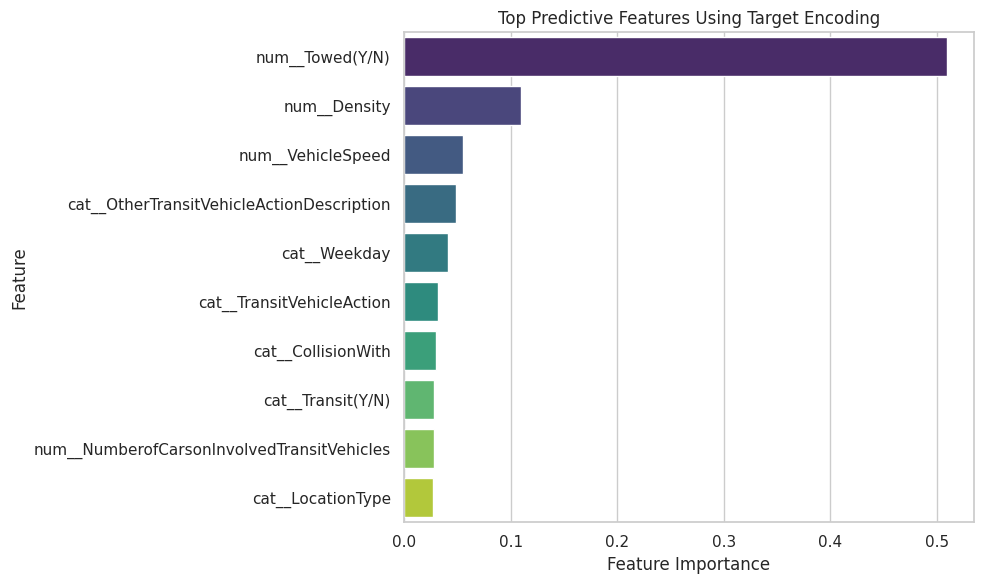

In [107]:
# Access trained classifier
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# Define parameter grid
param_grid_bagging = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_samples': [0.5, 0.75, 1.0],
    'classifier__max_features': [0.5, 0.75, 1.0],
    'classifier__bootstrap': [True, False],
   'classifier__estimator__max_depth': [3, 5, 7]  # Base DecisionTreeClassifier parameters
}

# GridSearchCV
grid_search_bagging = GridSearchCV(
    estimator=Pipeline_2, param_grid=param_grid_bagging, cv=5, n_jobs=-1, verbose=2, scoring='accuracy'
)

# Fit GridSearchCV
grid_search_bagging.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters for BaggingClassifier:", grid_search_bagging.best_params_)

# Best model
best_bagging_model = grid_search_bagging.best_estimator_



Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters for BaggingClassifier: {'classifier__bootstrap': True, 'classifier__estimator__max_depth': 7, 'classifier__max_features': 1.0, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 150}


In [108]:
Pipeline_2.fit(X_train, y_train)
y_pred = Pipeline_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2785
           1       0.77      1.00      0.87      9500

    accuracy                           0.77     12285
   macro avg       0.39      0.50      0.44     12285
weighted avg       0.60      0.77      0.67     12285

Confusion Matrix:
[[   0 2785]
 [   0 9500]]
ROC-AUC Score: 0.5



Top 10 Predictive Features:
                                       Feature  Importance  \
1                              num__Towed(Y/N)    0.540511   
10                          cat__CollisionWith    0.083786   
6                                 num__Density    0.073379   
4   num__NumberofCarsonInvolvedTransitVehicles    0.070772   
13   cat__OtherTransitVehicleActionDescription    0.044143   
14                           cat__Transit(Y/N)    0.038457   
12                   cat__TransitVehicleAction    0.034800   
3     num__NumberofNon-TransitVehiclesInvolved    0.033568   
5                            num__VehicleSpeed    0.025885   
0                          num__FixedRouteFlag    0.016283   

                              Original Feature  
1                              num__Towed(Y/N)  
10                          cat__CollisionWith  
6                                 num__Density  
4   num__NumberofCarsonInvolvedTransitVehicles  
13   cat__OtherTransitVehicleActionDescript

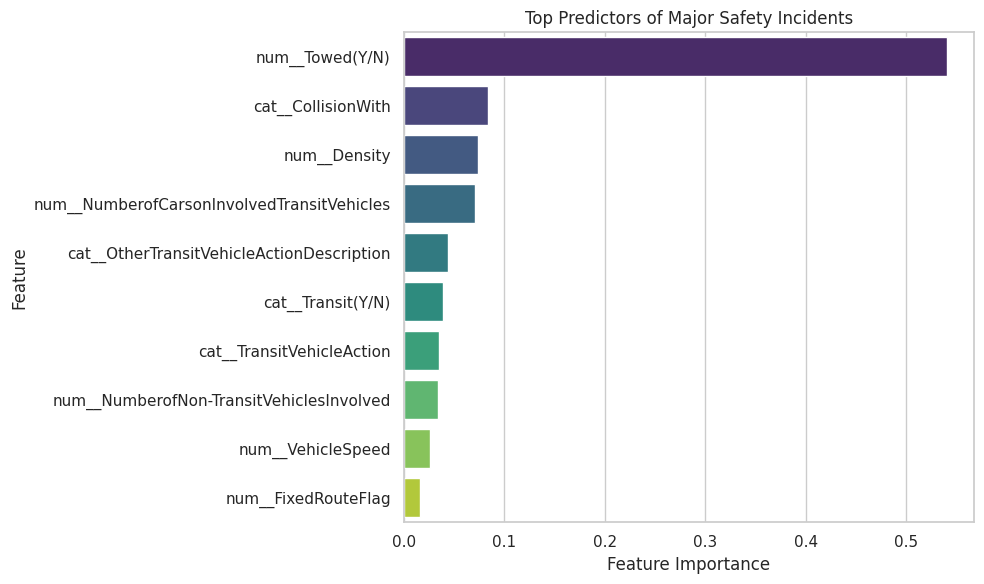

In [109]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model


rf_model = Pipeline_2.named_steps['classifier']

# Get feature names
ohe = Pipeline_2.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_2.named_steps['preprocessing'].get_feature_names_out()


# Get importances
importances = np.mean([
            tree.feature_importances_ for tree in rf_model.estimators_
        ], axis=0)


feat_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

# Get importances
#importances = rf_model.feature_importances_
#feat_importance_df = pd.DataFrame({
#    'Feature': all_feature_names,
#    'Importance': importances
#}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)


top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# Define the parameter grid
param_grid_et = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]

}

# Initialize ExtraTreesClassifier
et = ExtraTreesClassifier()

# Initialize GridSearchCV
grid_search_et = GridSearchCV(estimator=Pipeline_3, param_grid=param_grid_et, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search_et.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters for ExtraTreesClassifier:", grid_search_et.best_params_)

# Best model
best_et_model = grid_search_et.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters for ExtraTreesClassifier: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}


In [110]:
Pipeline_3.fit(X_train, y_train)

# Predict on Test Set
y_pred = Pipeline_3.predict(X_test)
y_probs = Pipeline_3.predict_proba(X_test)[:, 1]  # Probabilities for class 1


print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.26      0.36      2785
           1       0.81      0.95      0.88      9500

    accuracy                           0.79     12285
   macro avg       0.71      0.60      0.62     12285
weighted avg       0.77      0.79      0.76     12285

Confusion Matrix:
[[ 712 2073]
 [ 457 9043]]
ROC-AUC Score: 0.8705871680997826



Top 10 Predictive Features:
                                 Feature  Importance
1                             Towed(Y/N)    0.673871
6                                Density    0.048001
13  OtherTransitVehicleActionDescription    0.039702
14                          Transit(Y/N)    0.029064
5                           VehicleSpeed    0.026812
12                  TransitVehicleAction    0.025464
11                          LocationType    0.025109
10                         CollisionWith    0.023293
3    NumberofNon-TransitVehiclesInvolved    0.022397
15                               Weekday    0.021658


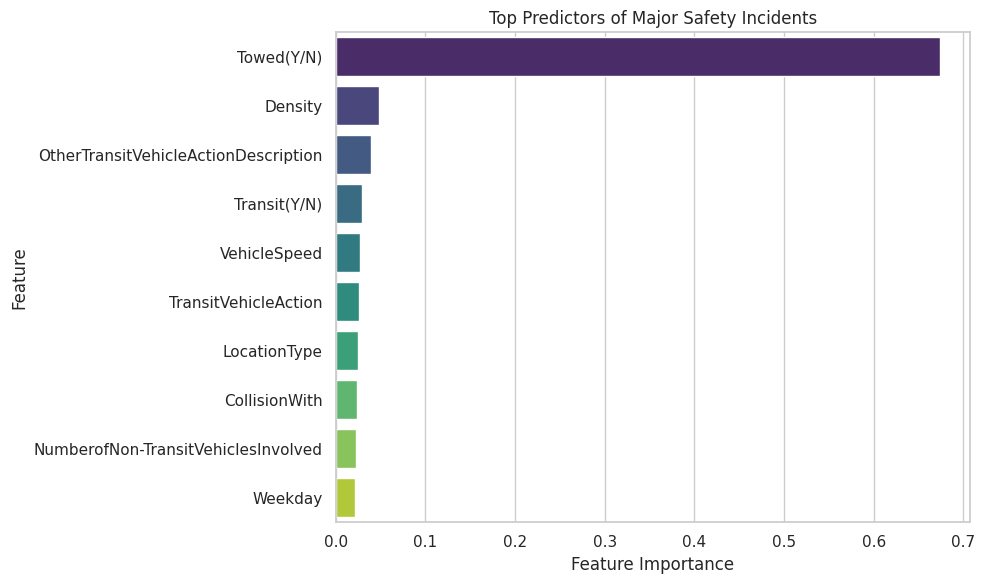

In [111]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_3.named_steps['classifier']

# Get feature names
ohe = Pipeline_3.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()